# Regression analysis on UCI superconductivity dataset using neurual network

# 0. make sure GPU is deployed

In [1]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# 1. Import UCI superconductor dataset and preprocessing

'Superconductivity' dataset, uploaded to UCI website in 2018, contains 21263 instances (superconducting materials) and 81 features.

https://github.com/AlexUCAS

In [2]:
!pip install scikeras
import pandas as pd
import numpy as np

df = pd.read_csv('https://raw.githubusercontent.com/AlexUCAS/ML_SC_LR/main/train.csv')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


81 features plus the target, the critical temperature, at the last colume.

In [3]:
df.shape

(21263, 82)

In [4]:
df.head()

,number_of_elements,mean_atomic_mass,wtd_mean_atomic_mass,gmean_atomic_mass,wtd_gmean_atomic_mass,entropy_atomic_mass,wtd_entropy_atomic_mass,range_atomic_mass,wtd_range_atomic_mass,std_atomic_mass,...,wtd_mean_Valence,gmean_Valence,wtd_gmean_Valence,entropy_Valence,wtd_entropy_Valence,range_Valence,wtd_range_Valence,std_Valence,wtd_std_Valence,critical_temp
0,4,88.944468,57.862692,66.361592,36.116612,1.181795,1.062396,122.90607,31.794921,51.968828,...,2.257143,2.213364,2.219783,1.368922,1.066221,1,1.085714,0.433013,0.437059,29.0
1,5,92.729214,58.518416,73.132787,36.396602,1.449309,1.057755,122.90607,36.161939,47.094633,...,2.257143,1.888175,2.210679,1.557113,1.047221,2,1.128571,0.632456,0.468606,26.0
2,4,88.944468,57.885242,66.361592,36.122509,1.181795,0.975980,122.90607,35.741099,51.968828,...,2.271429,2.213364,2.232679,1.368922,1.029175,1,1.114286,0.433013,0.444697,19.0
3,4,88.944468,57.873967,66.361592,36.119560,1.181795,1.022291,122.90607,33.768010,51.968828,...,2.264286,2.213364,2.226222,1.368922,1.048834,1,1.100000,0.433013,0.440952,22.0
4,4,88.944468,57.840143,66.361592,36.110716,1.181795,1.129224,122.90607,27.848743,51.968828,...,2.242857,2.213364,2.206963,1.368922,1.096052,1,1.057143,0.433013,0.428809,23.0


Delete features that have little correlation with the target.(|correlation| < 0.2)


In [5]:
correlationWithTarget = df.corr().iloc[:, -1:]
correlationWithTarget = correlationWithTarget.loc[correlationWithTarget['critical_temp'].abs() >= 0.2]  
index = correlationWithTarget.index
df = df[index]
df.shape

(21263, 67)

We can have even less features: get the 'smallest' subset of the 66 features where the features are correlated with all the 66 features


In [6]:
# pick out features highly correlated; keep independent features as least as possible
correlationMatrix = df.corr()
# build a dataframe 'a': index is features, the 1st and 2nd column is the list of correlated features 
# and the number of correlated features 
a = pd.Series(dtype='float64')  # the list of correlated features 
b = pd.Series(dtype='float64')  # the number of correlated features
for feature in df.columns[:-1]:
  a[feature] = correlationMatrix[feature].loc[correlationMatrix[feature] > 0.8].index.tolist()
  a[feature].remove(feature)  # remove the feature itself from the list
  b[feature] = len(a[feature])
a = pd.concat([a, b], axis=1).reset_index()  
a.set_index('index', inplace=True)
a.sort_values(1, inplace=True, ascending=False)

a = a[a[1] > 0]  # remove features that have no correlation with the rest
abundant = []  # the features supposed to be removeded among those that have correlation with others
while (a[1] != 0).sum() != 0:
  abundant.append(a.index[-1])
  for higherPoint in a.iloc[-1, 0]:  # considering a graph connecting correlated features 
                                     # where features correlated with more features locate higher
    a.loc[higherPoint, 0].remove(a.index[-1])
    a.loc[higherPoint, 1] = len(a.loc[higherPoint, 0])
  a = a.iloc[:-1, :]
  a = a[a[1] > 0]
  a.sort_values(1, inplace=True, ascending=False)
df.drop(columns=abundant, inplace=True)
df.shape

(21263, 18)

Split the dataset into 70% train data, 15% validation data, 15% test data and normalize the data.

In [7]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(df, test_size=0.15, random_state=1)

# normalized to zero mean and unit standard deviation
mean = train_data.iloc[:, :-1].mean(axis=0)
train_data.iloc[:, :-1] -= mean
std = train_data.iloc[:, :-1].std(axis=0)
train_data.iloc[:, :-1] /= std
test_data.iloc[:, :-1] -= mean
test_data.iloc[:, :-1] /= std

train_data, val_data = train_test_split(train_data, test_size=0.1765, random_state=1)
print(train_data.shape, val_data.shape, test_data.shape)

(14883, 18) (3190, 18) (3190, 18)


In [8]:
train_data.head()

,wtd_std_atomic_mass,wtd_range_fie,entropy_atomic_radius,wtd_range_atomic_radius,range_Density,wtd_range_Density,gmean_ElectronAffinity,wtd_std_ElectronAffinity,wtd_mean_FusionHeat,std_FusionHeat,mean_ThermalConductivity,wtd_mean_ThermalConductivity,wtd_gmean_ThermalConductivity,std_ThermalConductivity,mean_Valence,wtd_range_Valence,std_Valence,critical_temp
15073,-0.705376,0.508329,-1.763342,-0.197536,-1.621223,-0.592641,-0.851620,-2.120611,2.124909,1.256743,-1.756018,-1.227458,-0.051924,-1.562136,-0.187501,0.676902,-1.729178,6.80
3552,0.164527,0.894146,0.636654,-0.335941,0.072904,-0.316579,-0.055328,0.260460,-0.587718,-0.440613,-0.005968,0.391051,-0.645288,0.937297,-0.760590,-0.456727,-0.719841,93.65
19383,0.387662,-1.388282,0.411466,-0.084925,-0.191950,-0.476676,0.891556,2.302554,-0.185803,0.214094,-1.590065,-1.096430,-0.593461,-1.126157,-0.378530,-0.491677,1.004120,57.10
13653,-1.538644,-0.281217,0.302794,0.236694,-1.627320,0.046281,1.352034,0.013530,-0.053282,0.313678,-0.953543,-1.018937,-0.325571,-1.147448,1.006436,1.476649,0.515983,1.64
15940,-1.434986,-0.034351,-0.468815,2.609527,-1.511965,1.361228,0.858537,-1.655916,0.549449,0.024582,-1.013945,-0.543162,0.718359,-1.397789,1.404414,2.151503,-0.757943,17.70


# 2. Build the network

In [9]:
from keras import models, layers


# customized neural network
def build_model(hidden_layers, dropout_rate):
  model = models.Sequential()
  model.add(layers.Dense(hidden_layers[0], activation='relu', input_shape=(train_data.shape[1]-1,)))
  if dropout_rate !=0:
    model.add(layers.Dropout(dropout_rate))
    for hidden_layer in hidden_layers[1:]:
      model.add(layers.Dense(hidden_layer, activation='relu'))
      model.add(layers.Dropout(dropout_rate))
  else:
    for hidden_layer in hidden_layers[1:]:
      model.add(layers.Dense(hidden_layer, activation='relu'))
  model.add(layers.Dense(1))
  model.compile(optimizer='rmsprop', loss='mse', metrics=['mae']) 
  return model

In [10]:
# hidden_layers = np.ones(10) * 640  # 10 hidden layers with 64 cells in each hidden layer

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
from numpy import round_
plt.style.use('seaborn-talk')


def plot_mae(cut_off):
  mae = history.history['mae']
  val_mae = history.history['val_mae']
  epochs = range(1, len(mae) + 1)

  fig = plt.figure()
  ax = fig.add_subplot(2, 1, 1)
  ax.plot(epochs, mae, 'bo', label='training mae', markersize=1.5)
  ax.plot(epochs, val_mae, 'r', label='validation mae', linewidth=1)
  ax.set_title('Training and validation score')
  ax.set_xlabel('Epochs')
  ax.set_ylabel('mae')
  ax.legend()
  ax.grid()

  ax1 = fig.add_subplot(2, 1, 2)
  ax1.plot(epochs, mae, 'bo', label='training mae', markersize=1.5)
  ax1.plot(epochs, val_mae, 'r', label='validation mae', linewidth=1)
  ax1.set_xlabel('Epochs')
  ax1.set_ylabel('mae')
  ax1.legend()
  ax1.set_ylim([min(mae)-0.2, mae[cut_off]])
  ax1.grid()
  plt.tight_layout()

  plt.show()
  print('train_mae min', round_(min(mae), 3), 'val_mae min', round_(min(val_mae), 3))
  return 0

# 3. Fitting

After playing with the hyperparameters, including number of layers, number of cells in each layer, batch size, epochs and dropout rate, a typical valid fitting is done with 11 hidden layers with 1024 cells in each hidden layer and 0.3 dropout rate.

In [27]:
hidden_layers = np.ones(11) * 1024
model = build_model(hidden_layers, 0.3)
history = model.fit(train_data.iloc[:, :-1], train_data.iloc[:, -1], epochs=900, 
          batch_size=4961, verbose=0, validation_data=(val_data.iloc[:, :-1], val_data.iloc[:, -1]))

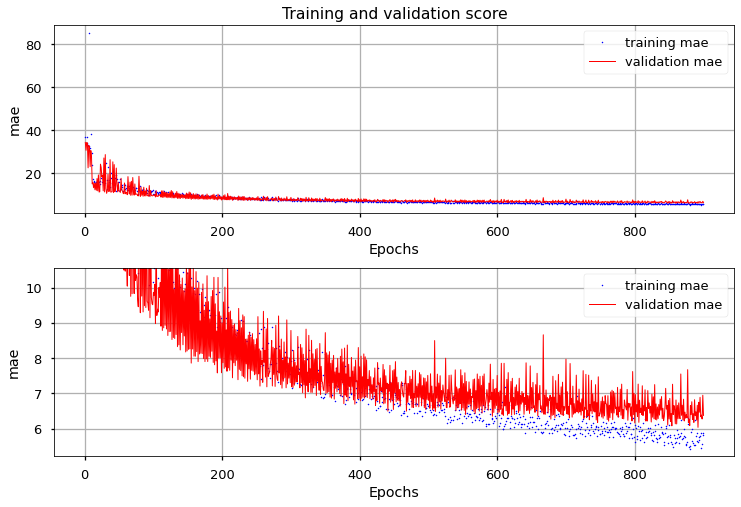

train_mae min 5.414 val_mae min 6.033


0

In [29]:
plot_mae(100)

We can see the val_mae becomes constant at around 600 epochs-overfitting happens after 600 epochs. So we study how well the model work after 600 epochs.

In [14]:
hidden_layers = np.ones(11) * 1024
model = build_model(hidden_layers, 0.3)
history = model.fit(train_data.iloc[:, :-1], train_data.iloc[:, -1], epochs=600, 
          batch_size=4961, verbose=0, validation_data=(val_data.iloc[:, :-1], val_data.iloc[:, -1]))

train_mae min 5.551 val_mae min 6.041


The mean absolute error (MAE) of validation data, r2 score and root-mean-square error on the test data (to compare with other models) are calculated

In [15]:
val_mae = history.history['val_mae']
print('val_MAE = ', val_mae[-1])

from sklearn.metrics import r2_score, mean_squared_error

test_pred = model.predict(test_data.iloc[:, :-1])
print('r2 score = ', r2_score(test_data['critical_temp'], test_pred))
print('Root-mean-square error = ', np.sqrt(mean_squared_error(test_data['critical_temp'], test_pred)))

val_MAE =  7.164188861846924
100/100 [==============================] - 0s 2ms/step
r2 score =  0.8917363067514281
Root-mean-square error =  11.246243296260602


RMSE around 12 is partly acceptable as domonstrated in the comparison between actual critical temperatures and predicted ones.

100/100 [==============================] - 0s 2ms/step


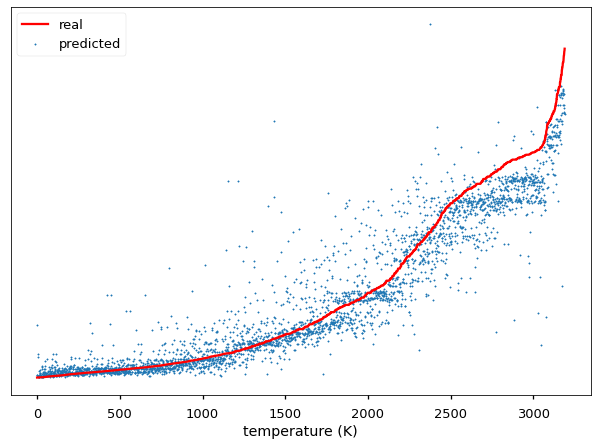

In [16]:
test_data.sort_values(by='critical_temp', ignore_index=True, inplace=True)
plt.plot(np.linspace(0, 3189, 3190), test_data.iloc[:, -1], c='r', label='real')
plt.scatter(np.linspace(0, 3189, 3190), model.predict(test_data.iloc[:, :-1]), c='C0', s=2, label='predicted')
plt.legend()
plt.yticks([])
plt.xlabel('temperature (K)')
plt.show()

Text(0, 0.5, 'temperature (K)')

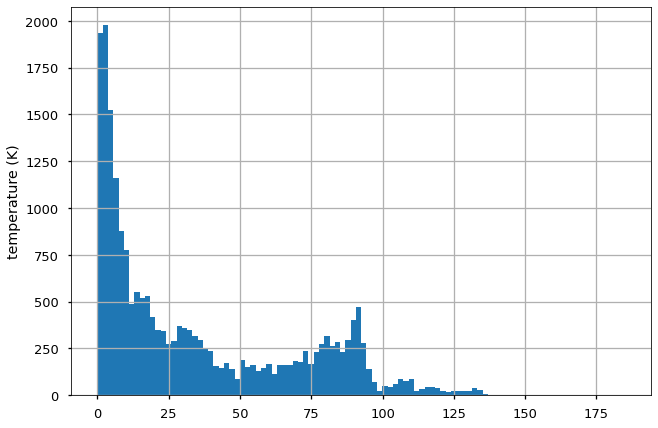

In [17]:
df['critical_temp'].hist(bins=100)
plt.ylabel('temperature (K)')

The error at high temperature comes from the unbalanced distribution of the dataset.

# Fun fact

A less-expensive method, random forest, works even better than a deep neural network.

In [18]:
from sklearn.ensemble import RandomForestRegressor

rnd = RandomForestRegressor(n_estimators=500, verbose=0)

In [19]:
rnd.fit(train_data.iloc[:, :-1].values, train_data['critical_temp'])
print('rf r2_score', r2_score(test_data['critical_temp'], rnd.predict(test_data.iloc[:, :-1].values)))

rf r2_score 0.9199428349447779


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


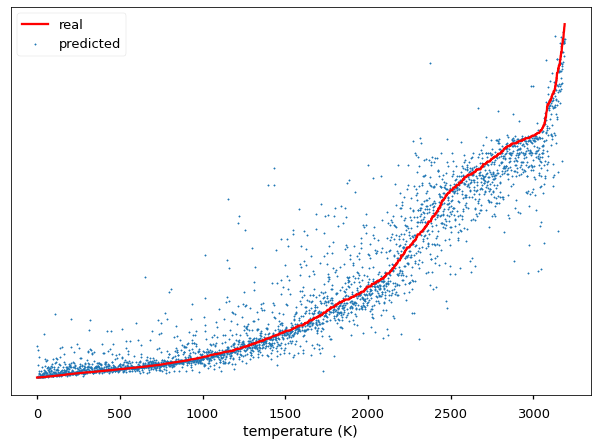

In [20]:
plt.plot(np.linspace(0, 3189, 3190), test_data['critical_temp'], c='r', label='real')
plt.scatter(np.linspace(0, 3189, 3190), rnd.predict(test_data.iloc[:, :-1]), c='C0', s=2, label='predicted')
plt.legend()
plt.yticks([])
plt.xlabel('temperature (K)')

plt.show()

Unfortunately, ensemble learning doesn't imporve the fitting.

In [21]:
def build_NN():
  hidden_layers = np.ones(11) * 1024
  dropout_rate = 0.3
  model = models.Sequential()
  model.add(layers.Dense(hidden_layers[0], activation='relu', input_shape=(train_data.shape[1]-1,)))
  if dropout_rate !=0:
    model.add(layers.Dropout(dropout_rate))
    for hidden_layer in hidden_layers[1:]:
      model.add(layers.Dense(hidden_layer, activation='relu'))
      model.add(layers.Dropout(dropout_rate))
  else:
    for hidden_layer in hidden_layers[1:]:
      model.add(layers.Dense(hidden_layer, activation='relu'))
  model.add(layers.Dense(1))
  model.compile(optimizer='rmsprop', loss='mse', metrics=['mae']) 
  return model

In [22]:
from sklearn.ensemble import VotingRegressor
from scikeras.wrappers import KerasRegressor

# convert keras model to sklearn regressor
NN = KerasRegressor(build_NN, epochs=600, verbose=0, batch_size=4961)
NN._estimator_type = 'regressor'

voting = VotingRegressor(estimators=[('NN', NN), ('rf', rnd)])
voting.fit(train_data.iloc[:, :-1].values, train_data.iloc[:, -1])

VotingRegressor(estimators=[('NN',
                             KerasRegressor(batch_size=4961, epochs=600, model=<function build_NN at 0x7f27684194d0>, verbose=0)),
                            ('rf', RandomForestRegressor(n_estimators=500))])

In [23]:
print('voting r2_score', r2_score(test_data['critical_temp'], voting.predict(test_data.iloc[:, :-1].values)))

voting r2_score 0.9119729075321759


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


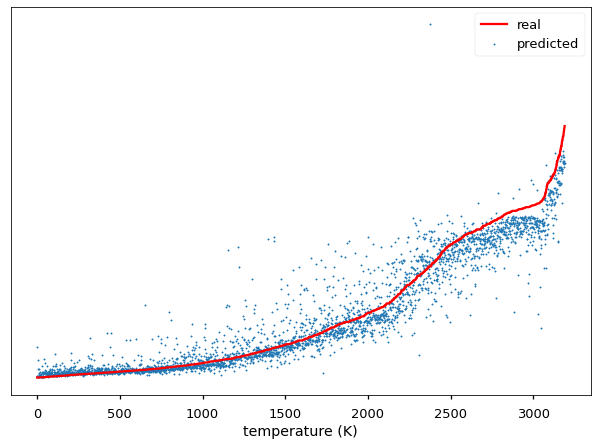

In [24]:
plt.plot(np.linspace(0, 3189, 3190), test_data['critical_temp'], c='r', label='real')
plt.scatter(np.linspace(0, 3189, 3190), voting.predict(test_data.iloc[:, :-1]), c='C0', s=2, label='predicted')
plt.legend()
plt.yticks([])
plt.xlabel('temperature (K)')
plt.show()